In [2]:
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
edges = pd.read_csv('7th_graders/edges.csv')
nodes = pd.read_csv('7th_graders/nodes.csv')

print(edges.shape, edges.columns)
print(nodes.shape)

(740, 4) Index(['source', 'target', 'weight', 'layer'], dtype='object')
(29, 3)


In [4]:
edge_list = edges[['source', 'target']].values.tolist()

G = nx.DiGraph()

G.add_edges_from(edge_list)

for _, row in nodes.iterrows():
    G.add_node(row['index'], name=row['name'], pos=row['_pos'])


print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  376
Number of nodes:  29


In [5]:
def random_strategy(G, num_pivots):
    """
    Select nodes uniformly at random.
    """
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)

In [6]:
import numpy as np

# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [7]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [8]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots
pivots = pagerank_pivot_selection(G, 3)
pivots

[13, 15, 18]

In [9]:
def euclidean_distance(exact, estimated):
    """
    Compute the Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    return np.linalg.norm(exact_values - estimated_values)

In [10]:
from itertools import combinations

def compute_inversion_distance(exact_scores, estimated_scores):
    # Rank the nodes based on scores (higher scores get lower ranks)
    exact_ranking = sorted(exact_scores.items(), key=lambda x: x[1], reverse=True)
    estimated_ranking = sorted(estimated_scores.items(), key=lambda x: x[1], reverse=True)

    # Create dictionaries to map nodes to their ranks
    exact_ranks = {node: rank for rank, (node, _) in enumerate(exact_ranking, 1)}
    estimated_ranks = {node: rank for rank, (node, _) in enumerate(estimated_ranking, 1)}

    # Count inversions
    inversion_count = 0
    for u, v in combinations(exact_scores.keys(), 2):  # Compare all pairs of nodes
        exact_order = exact_ranks[u] - exact_ranks[v]  # Positive if u ranks higher than v
        estimated_order = estimated_ranks[u] - estimated_ranks[v]  # Positive if u ranks higher than v
        
        if exact_order * estimated_order < 0:  # Orders are inverted
            inversion_count += 1

    return inversion_count


## closeness centrality

In [11]:
def estimate_closeness_centrality(G, pivots):
    closeness_estimates = {}
    for node in G.nodes:
        distances = []
        for pivot in pivots:
            shortest_paths = nx.single_source_shortest_path_length(G, source=pivot)
            distance = shortest_paths.get(node, float('inf'))
            distances.append(distance)
        
        finite_distances = [d for d in distances if d != float('inf')]
        if finite_distances:
            avg_distance = sum(finite_distances) / len(finite_distances)
            closeness_estimates[node] = 1 / avg_distance if avg_distance > 0 else 0
        else:
            closeness_estimates[node] = 0
    return closeness_estimates


In [12]:
exact_closeness = nx.closeness_centrality(G)
print('Exact closeness centrality: ', exact_closeness)

Exact closeness centrality:  {0: 0.5957446808510638, 5: 0.5, 7: 0.6363636363636364, 10: 0.7, 11: 0.5833333333333334, 13: 0.7567567567567568, 15: 0.7567567567567568, 16: 0.6511627906976745, 18: 0.7368421052631579, 20: 0.7, 21: 0.7, 25: 0.717948717948718, 26: 0.6829268292682927, 1: 0.6829268292682927, 4: 0.6666666666666666, 2: 0.509090909090909, 3: 0.5714285714285714, 6: 0.5, 9: 0.5490196078431373, 14: 0.7, 19: 0.7, 8: 0.5185185185185185, 22: 0.7, 27: 0.5957446808510638, 28: 0.6511627906976745, 23: 0.6511627906976745, 12: 0.5714285714285714, 17: 0.5490196078431373, 24: 0.56}


In [13]:
def run_experiment_closeness(G, pivot_strategy, runs=20):
    exact_closeness = nx.closeness_centrality(G)
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    results = []
    
    for run in range(runs):
        for num_pivots in num_pivots_list:
            pivots = pivot_strategy(G, num_pivots)
            estimated_closeness = estimate_closeness_centrality(G, pivots)
            euclidean_dist = euclidean_distance(exact_closeness, estimated_closeness)
            results.append({
                "run": run,
                "num_pivots": num_pivots,
                "strategy": pivot_strategy.__name__,
                "euclidean_distance": euclidean_dist,
                "estimated_closeness": estimated_closeness
            })
    return pd.DataFrame(results)     

In [14]:
strategies = [random_strategy, pagerank_pivot_selection, ran_indeg_strategy, ran_outdeg_strategy]

all_results_closeness = pd.DataFrame()
for strategy in strategies:
    strategy_results = run_experiment_closeness(G, strategy)
    all_results_closeness = pd.concat([all_results_closeness, strategy_results], ignore_index=True)


all_results_closeness.head()

,run,num_pivots,strategy,euclidean_distance,estimated_closeness
0,0,1,random_strategy,1.675071,"{0: 1.0, 5: 1.0, 7: 1.0, 10: 1.0, 11: 0.5, 13:..."
1,0,2,random_strategy,0.931934,"{0: 0.5, 5: 0.6666666666666666, 7: 0.666666666..."
2,0,4,random_strategy,1.062820,"{0: 0.5, 5: 0.6666666666666666, 7: 0.666666666..."
3,0,5,random_strategy,0.658299,"{0: 0.625, 5: 0.5, 7: 0.7142857142857143, 10: ..."
4,0,7,random_strategy,0.576441,"{0: 0.6363636363636364, 5: 0.6363636363636364,..."


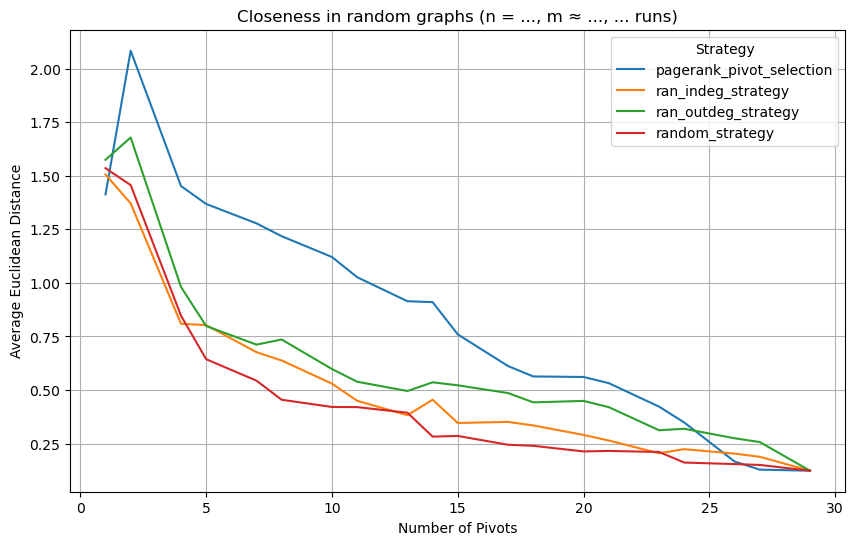

In [15]:
import matplotlib.pyplot as plt

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped = all_results_closeness.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

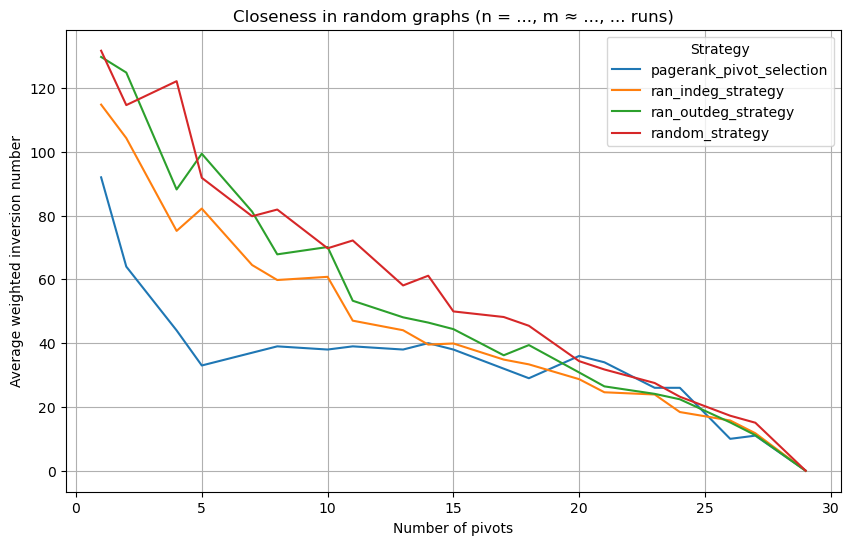

In [16]:
all_results_closeness["inversion_distance"] = all_results_closeness["estimated_closeness"].apply(
    lambda est_closeness: compute_inversion_distance(exact_closeness, est_closeness)
)
all_results_closeness["inversion_distance"].head()

# Group by `num_pivots` and `strategy` to compute the average inversion distance
avg_inversion = all_results_closeness.groupby(["num_pivots", "strategy"])["inversion_distance"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot each strategy
for strategy in avg_inversion["strategy"].unique():
    strategy_data = avg_inversion[avg_inversion["strategy"] == strategy]
    plt.plot(
        strategy_data["num_pivots"],
        strategy_data["inversion_distance"],
        label=strategy
    )

# Add labels, legend, and title
plt.xlabel("Number of pivots")
plt.ylabel("Average weighted inversion number")
plt.title("Closeness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

## betweenness centrality

In [17]:
def estimate_betweenness_centrality(G, pivots):
    betweenness_estimates = {node: 0 for node in G.nodes}

    for pivot in pivots:
        # Compute shortest paths from the current pivot
        shortest_paths = nx.single_source_shortest_path_length(G, source=pivot)
        
        # Initialize a dictionary to count paths passing through each node
        dependency = {node: 0 for node in G.nodes}
        
        # Backtrack from all nodes to the pivot to count dependencies
        for target in shortest_paths:
            if target == pivot:
                continue  # Skip the pivot itself
            path = nx.shortest_path(G, source=pivot, target=target)
            for node in path[1:-1]:  # Ignore source and target in the path
                dependency[node] += 1
        
        # Normalize dependencies and add to betweenness estimates
        for node, count in dependency.items():
            betweenness_estimates[node] += count / len(shortest_paths)
    
   # Normalize the betweenness estimates for directed graphs
    n = len(G.nodes)
    for node in betweenness_estimates:
        betweenness_estimates[node] /= (n - 1) * (n - 2)

    return betweenness_estimates


In [18]:
exact_betweenness = nx.betweenness_centrality(G)
print('Exact closeness centrality: ', exact_betweenness)

Exact closeness centrality:  {0: 0.007113760780128759, 5: 0.01889477732731701, 7: 0.07877895277929498, 10: 0.09857357551381395, 11: 0.008695823013820067, 13: 0.016418761897278714, 15: 0.043782859792013906, 16: 0.015490604734347947, 18: 0.020509306737959063, 20: 0.011731479441819095, 21: 0.012535636238959563, 25: 0.003544767499793955, 26: 0.006147327639756029, 1: 0.0416713032376623, 4: 0.03181754073244498, 2: 0.041366190193448706, 3: 0.0087266138905192, 6: 0.0, 9: 0.007288751289167799, 14: 0.009528320481407684, 19: 0.023299983957672358, 8: 0.036249662618689754, 22: 0.009664581739194754, 27: 0.022722092147535396, 28: 0.029328101091412675, 23: 0.013923511554532354, 12: 0.014460917536314363, 17: 0.005241505879473388, 24: 0.009318687079618028}


In [19]:
def run_experiment_betweenness(G, pivot_strategy, runs=20):
    num_nodes = G.number_of_nodes()
    num_pivots_list = [int(num_nodes / 20 * i) for i in range(1, 21)]
    results = []
    
    for run in range(runs):
        for num_pivots in num_pivots_list:
            pivots = pivot_strategy(G, num_pivots)
            estimated_betweenness = estimate_betweenness_centrality(G, pivots)
            euclidean_dist = euclidean_distance(exact_betweenness, estimated_betweenness)
            results.append({
                "run": run,
                "num_pivots": num_pivots,
                "strategy": pivot_strategy.__name__,
                "euclidean_distance": euclidean_dist,
                "estimated_betweenness": estimated_betweenness
            })
    return pd.DataFrame(results)     

In [20]:
strategies = [random_strategy, pagerank_pivot_selection, ran_indeg_strategy, ran_outdeg_strategy]

all_results_betweenness = pd.DataFrame()
for strategy in strategies:
    strategy_results = run_experiment_betweenness(G, strategy)
    all_results_betweenness = pd.concat([all_results_betweenness, strategy_results], ignore_index=True)


all_results_betweenness.head()

,run,num_pivots,strategy,euclidean_distance,estimated_betweenness
0,0,1,random_strategy,0.167590,"{0: 4.5612114577631816e-05, 5: 0.0, 7: 0.0, 10..."
1,0,2,random_strategy,0.167238,"{0: 0.00031928480204342275, 5: 0.0, 7: 0.0, 10..."
2,0,4,random_strategy,0.166743,"{0: 0.00018244845831052726, 5: 4.5612114577631..."
3,0,5,random_strategy,0.166438,"{0: 0.00022806057288815912, 5: 0.0, 7: 0.00136..."
4,0,7,random_strategy,0.166299,"{0: 4.5612114577631816e-05, 5: 0.0002280605728..."


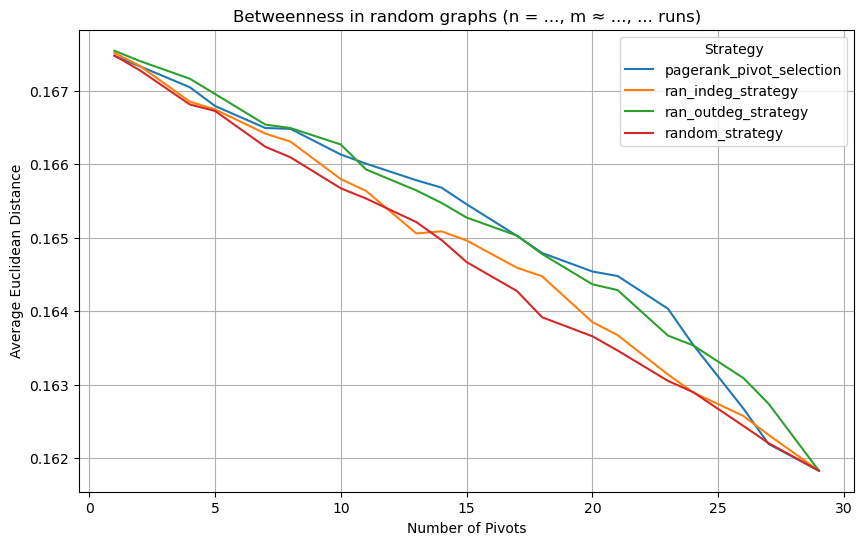

In [21]:
import matplotlib.pyplot as plt

# Group by strategy and number of pivots to calculate the mean Euclidean distance
grouped_betweenness = all_results_betweenness.groupby(["strategy", "num_pivots"])["euclidean_distance"].mean().unstack("strategy")

# Plot the results
grouped_betweenness.plot(figsize=(10, 6))
plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title(f"Betweenness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()

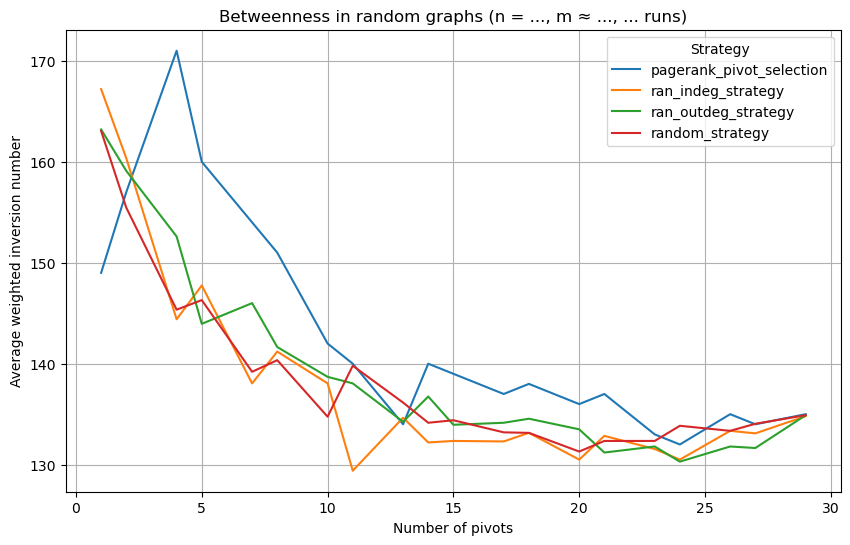

In [22]:
all_results_betweenness["inversion_distance"] = all_results_betweenness["estimated_betweenness"].apply(
    lambda est_betweenness: compute_inversion_distance(exact_betweenness, est_betweenness)
)
all_results_betweenness["inversion_distance"].head()

# Group by `num_pivots` and `strategy` to compute the average inversion distance
avg_inversion = all_results_betweenness.groupby(["num_pivots", "strategy"])["inversion_distance"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))

# Plot each strategy
for strategy in avg_inversion["strategy"].unique():
    strategy_data = avg_inversion[avg_inversion["strategy"] == strategy]
    plt.plot(
        strategy_data["num_pivots"],
        strategy_data["inversion_distance"],
        label=strategy
    )

# Add labels, legend, and title
plt.xlabel("Number of pivots")
plt.ylabel("Average weighted inversion number")
plt.title("Betweenness in random graphs (n = ..., m ≈ ..., ... runs)")
plt.legend(title="Strategy")
plt.grid(True)
plt.show()